In [98]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5
from os.path import join
from functools import partial
from scipy.optimize import fsolve
from scipy.special import erf
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import multiprocessing as mp
from dynhalo.corrfunc.model import  rho_orb_model, power_law
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

import astropy.units as u
from astropy.constants import G, M_sun
Mpc = ((1 * u.Mpc).to(u.km)).value

yr = (1 * u.yr).to(u.s).value

G_gravity = (G.to(u.Mpc * (u.km / u.s)**2 / M_sun)).value


class DF:
    def __init__(self, halomass_bins, galaxysm_bins, pars_mle, m_pivot):
        self.halomass_bins =  halomass_bins
        self.galaxysm_bins = galaxysm_bins
        self.density_profile_pars = [pars_mle, m_pivot]


    def m_sm_model(self, x, alpha, beta, gamma, epsilon, logM_p, logM_t):
        M_p = 10**logM_p
        M_t = 10**logM_t
        return epsilon*(x/M_p)**alpha/(1+(x/M_p)**beta)*1/(1+(x/M_t)**gamma)


    def get_subhalomass(self, stellarmass, ratio):
        def equation(sub, sm):
            return sm/sub - ratio(sub)
        sub_init = stellarmass
        solution = fsolve(equation, sub_init, args=(stellarmass,))
        return solution[0]
    

    def set_subhalomass(self, path, name):
        with h5.File(join(path, name), "r") as f:
            bestfit_pars = f["bestfit_pars"][:]

        ratio =  partial(self.m_sm_model, alpha=bestfit_pars[0], beta=bestfit_pars[1], gamma=bestfit_pars[2], epsilon=bestfit_pars[3], logM_p=bestfit_pars[4], logM_t=bestfit_pars[5])

        self.subhalomass_bins = np.array([self.get_subhalomass(sm, ratio) for sm in self.galaxysm_bins])
        return None
    

    def factor_model(self, v, sigma):
        x = v/sigma
        x = abs(x) # x=abs(vr/sigma)
        return erf(x/np.sqrt(2))-(2/np.pi)**0.5*x*np.exp(-x**2/2)


    def set_factor(self, path, name):
        with h5.File(join(path, name), "r") as f:
            sigma = (f['sigma'][()])

        len_sigma = len(sigma)
        self.factor = [None for _ in range(len_sigma)]
        for i in range(len_sigma):
            self.factor[i] = partial(self.factor_model, sigma = sigma[i])
        return None
        

    def mass_func(self, r, morb):
        halo_index = np.where(self.halomass_bins == morb)[0][0]
        if r >= 0:
            return self.mass_interp[halo_index](r)
        else:
            return -self.mass_interp[halo_index](abs(r))
                  

    def set_mass_func(self, path, name):
        with h5.File(join(path, name), "r") as f:
            mass_value = f["mass"][()]
            r_linspace = f["r"][()]

        mass_interp = []
        for i in range(len(mass_value)):
            mass_interp.append(CubicSpline(r_linspace, mass_value[i]))
        
        self.mass_interp = mass_interp
        return None
    

    def get_eta(self, halomass, galaxymass, alpha, beta):  
        return alpha*np.log10(galaxymass/halomass) + beta
     

    def density_profile(self, r, morb):
        pars_mle, m_pivot = self.density_profile_pars
        rh_p, rh_s, alpha_p, alpha_s, a, *rest = pars_mle
        r_h = power_law(morb / m_pivot, p=rh_p, s=rh_s)
        alpha = power_law(morb/ m_pivot, p=alpha_p, s=alpha_s)
        return rho_orb_model(abs(r), morb=morb, r_h=r_h, alpha=alpha, a=a)


    def density_factor(self, vr, r, morb):
        halo_index = np.where(self.halomass_bins == morb)[0][0]
        factor = self.factor[halo_index]
        return factor(abs(vr))*self.density_profile(r, morb)
    

    def find_radius(self, t, r):
        peaks, _ = find_peaks(r)

        peak_indices, _ = find_peaks(r)

        peak_t= t[peak_indices]
        peak_r = r[peak_indices]

        peak_t = np.concatenate(([t[0]], peak_t))
        peak_r = np.concatenate(([r[0]], peak_r))

        if len(peak_t) == 0:
            return None
        else:
            return peak_t, peak_r
        

    def reshape_radius(self, r):
        zeropoint, _ = find_peaks(-np.abs(r))
        n = len(zeropoint)
        r_new = r.copy()
        
        if n % 2 == 0:
            for i in range(0, n, 2):
                r_new[zeropoint[i]:zeropoint[i+1]] = -r[zeropoint[i]:zeropoint[i+1]]
        else:
            for i in range(0, n-1, 2):
                r_new[zeropoint[i]:zeropoint[i+1]] = -r[zeropoint[i]:zeropoint[i+1]]
            r_new[zeropoint[-1]:] = -r[zeropoint[-1]:]
        return r_new
    

    def reshape_vel(self, vr):
        peaks_pos, _ = find_peaks(vr)
        peaks_neg, _ = find_peaks(-vr)

        n_pos = len(peaks_pos)
        n_neg = len(peaks_neg)

        vr_new = vr.copy()
        
        if n_neg == n_pos:
            for i in range(n_pos):
                vr_new[peaks_neg[i]: peaks_pos[i]] = -vr[peaks_neg[i]: peaks_pos[i]]
        else: # n_neg = n_pos + 1
            for i in range(n_pos):
                vr_new[peaks_neg[i]: peaks_pos[i]] = -vr[peaks_neg[i]: peaks_pos[i]]
            vr_new[peaks_neg[-1]:] = -vr_new[peaks_neg[-1]:]

        return vr_new


    def set_equs(self, t_span, y0, t_eval):
        self.t_span = t_span
        self.y0 = y0
        self.t_eval = t_eval
        return None


    def solve_equs_one_pair(self, halomass, galaxymass, alpha, beta):
        eta = self.get_eta(halomass, galaxymass, alpha, beta)
        def equs_DF(t, y):
            """
            v: km/s
            r: Mpc
            mass: M_sun
            t: 10^8 yr
            """
            r, vr = y

            if r<1e-8 and r>=0:
                r = 1e-8
            elif r<0 and r>=-1e-8:
                r = -1e-8
            
            if vr<1e-8 and vr>=0:
                vr = 1e-8
            elif vr<0 and vr>=-1e-8:
                vr = -1e-8

            dr_dt = vr/Mpc*(10**8*yr) 
            dvr_dt = (-G_gravity*self.mass_func(r, halomass) / r**2 - eta*G_gravity**2*galaxymass*self.density_factor(
                vr, r, halomass
                )*vr/abs(vr)**3) / Mpc*(10**8*yr)

            return [dr_dt, dvr_dt]
        
        halo_index = np.where(self.halomass_bins == halomass)[0][0]
        y0_temp = [self.y0[0][halo_index], self.y0[1]]
    
        sol = solve_ivp(equs_DF, self.t_span, y0_temp, t_eval=self.t_eval, method='Radau', atol=[1e-7, 1e-7], rtol=1e-4)

        t_full = sol.t
        r_full = sol.y[0]
        vr_full = sol.y[1]

        r_full = self.reshape_radius(r_full)
        vr_full = self.reshape_vel(vr_full)

        t_peak, r_peak = self.find_radius(t_full, r_full)

        zeroradius, _ = find_peaks(vr_full)
        zeropoint_time = t_full[zeroradius]
        zeropoint_vel = vr_full[zeroradius]

        results =  [t_full, r_full, vr_full] # (3,n)
        peaks = np.vstack((t_peak, r_peak)).T # (n,2)
        zeropoint = np.vstack((zeropoint_time, zeropoint_vel)).T # (n,2)

        return results, peaks, zeropoint

    def process_sample(self, index, alpha, beta):
            return index, *self.solve_equs_one_pair(self.halomass_bins[index[0]], self.subhalomass_bins[index[1]], alpha, beta)

    def solve_equs_total_pairs(self, alpha, beta, n_threads=32):
        indices = []
        for i in range(len(self.halomass_bins)):
            for j in range(len(self.subhalomass_bins)):
                indices.append([i, j])
        func = partial(self.process_sample, alpha=alpha, beta=beta)
        with mp.Pool(processes=n_threads) as pool:
            solutions = list(
                pool.imap(
                    func,
                    indices
                    ))
        theory_ratio = np.zeros((len(self.halomass_bins), len(self.subhalomass_bins)))
        for index, results, peaks, zeropoint in solutions: 
            theory_ratio[index[0], index[1]] = peaks[1,1]/peaks[0,1]

        return theory_ratio


    def plt_DF(self, ratio_data, ratio_theory, cov, sigma_int, logMBINEDGES):
        def colorbar(ax, fig, colors, MBINEDGES):
            """
            Add colorbar to the plot.
            
            Args:
            ax (matplotlib.axes._subplots.AxesSubplot): the axes of the plot.
            colors (list): list of colors.
            MBINEDGES (np.array): the bin edges.
            """            
            norm = mcolors.Normalize(vmin=0, vmax=len(colors))
            cmap = mcolors.ListedColormap(colors)
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(len(colors)), shrink=0.8, aspect=40)
            cbar.set_label(r'$Log_{10}M/M_\odot$', fontsize=13)
            cbar.set_ticks(np.arange(len(colors)+1))
            cbar.set_ticklabels([f'{i:.2f}' for i in MBINEDGES])

        ratio_mass = np.zeros((len(self.halomass_bins), len(self.galaxysm_bins)))
        for i in range(len(self.halomass_bins)):
            for j in range(len(self.galaxysm_bins)):
                ratio_mass[i, j] = self.galaxysm_bins[j]/self.halomass_bins[i]
            
        fig, axs = plt.subplots(1, 1, figsize=(10, 6))
        colors = []
        color_func =  cm.viridis(np.linspace(0, 1, len(logMBINEDGES)-1))
        for i in range(len(self.halomass_bins)):
            colors.append(color_func[i])
            axs.errorbar(
                ratio_mass[i, :], ratio_data[i, :]+0.2*i, 
                np.sqrt(np.diag(cov)[i*5:(i+1)*5]), 
                fmt='o', markersize=5, markerfacecolor='none', 
                ecolor=color_func[i], elinewidth=2, capsize=5, capthick=1,
                linestyle='', color=color_func[i],
                )
            axs.errorbar(
                ratio_mass[i, :], ratio_theory[i, :]+0.2*i, 
                sigma_int*ratio_theory[i, :],
                fmt='^', markersize=5, markerfacecolor='none', 
                ecolor=color_func[i], elinewidth=2, capsize=5, capthick=1,
                linestyle='-', color=color_func[i],
                )

        axs.set_xlabel(r"$M_*/M_{orb}$", fontsize=13)
        axs.set_ylabel(r"$r_{hg}/r_{hm}$", fontsize=13)

        axs.set_xscale("log")
        axs.grid(True)
        colorbar(axs, fig, colors, logMBINEDGES[:len(self.halomass_bins)+1])

        axs.set_ylim(0.6, 2.0)
        axs.set_xlim(10**-6, 10**-2.5)

        custom_lines = [
            Line2D([0], [0], color='k', lw=2, linestyle='-'),
            Line2D([0], [0], color='k', lw=2, linestyle='--')
        ]

        # Adding the custom legend
        legend1 = axs.legend(custom_lines, ['Curve of Theory', 'Curve of Data'], loc='upper right', handlelength=4)
        axs.add_artist(legend1)
        plt.show()

        return fig, axs
    
    def get_lglkl(self, alpha, beta, sigma_int, ratio_data, cov, n_threads=32):
        ratio_theory = self.solve_equs_total_pairs(alpha, beta, n_threads=n_threads)
        ratio_data = ratio_data.reshape(ratio_data.shape[0]*ratio_data.shape[1])
        ratio_theory = ratio_theory.reshape(ratio_theory.shape[0]*ratio_theory.shape[1])

        diff = ratio_data - ratio_theory
        cov = cov + np.diag(sigma_int**2 * ratio_theory**2)
        cov_inv = np.linalg.pinv(cov)
        return -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))-0.5*np.log(np.linalg.det(cov))

In [99]:
filepath = "/spiff/cwu18/project/massbins/mdpl2"
filename = "halo_morb_fit.h5"
with h5.File(join(filepath, filename), "r") as f:
    halomass = f["fit_morb"][()]

filepath = "/spiff/cwu18/project/massbins/mdpl2"
filename = "galaxy_sm_median.h5"
with h5.File(join(filepath, filename), "r") as f:
    galaxysm = f["median_sm"][()]

path = "/spiff/cwu18/project/halo_mass/mdpl2/fit"
mle_file="mle_full_fixMorb.h5"
mle_name="mle"
with h5.File(join(path, mle_file), "r") as f:
    pars_mle = f["max_posterior"][mle_name][()]

m_pivot = 10**14

# init =============================================================================
DF_mdpl2 = DF(halomass, galaxysm, pars_mle, m_pivot)

# set_subhalomass =============================================================================

path = "/spiff/cwu18/project/dynamical_friction/m_sm"
name = "bestfit_pars.h5"

DF_mdpl2.set_subhalomass(path, name)

# set_factor =============================================================================
path = "/spiff/cwu18/project/velocity_distribution/mdpl2/cdf/MB_fit"
name = "best_fit_pars_0_1.h5"

DF_mdpl2.set_factor(path, name)


# set_mass_func =============================================================================
path = "/spiff/cwu18/project/dynamical_friction/mdpl2/mass_func"
name = "mdpl2_mass_func_full.h5"

DF_mdpl2.set_mass_func(path, name)

# set_equs =============================================================================
rh = power_law(halomass / m_pivot, p=pars_mle[0], s=pars_mle[1])

tmax  = 40
t_span = [0, tmax]
y0 = [rh, -1e-10]  
t_eval = np.linspace(0, tmax, 1000) 

DF_mdpl2.set_equs(t_span, y0, t_eval)

In [84]:
n_threads = 32
alpha = -6.38
beta = -4.65
ratio_theory = DF.solve_equs_total_pairs(DF_mdpl2, alpha=alpha, beta=beta, n_threads=n_threads)

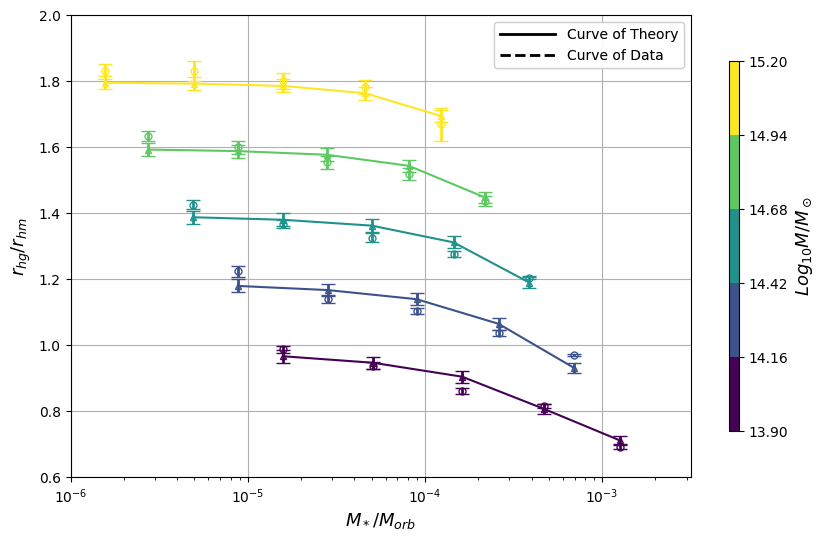

In [88]:
SRC_PATH = "/spiff/cwu18/project/halo_mass/mdpl2/corr_func"
filename = f"xihm_mdpl2_full.h5"
with h5.File(join(SRC_PATH, filename), "r") as f:
    logMBINEDGES = f["logMBINEDGES"][()]

path ='/spiff/cwu18/project/dynamical_friction/mdpl2/ratio_hghm_binbybin'
with h5.File(join(path, "ratio_smooth.h5"), "r") as f:
    ratio_data = f["ratio"][()]
    cov = f["cov"][()]

sigma_int = 0.02

DF_mdpl2.plt_DF(ratio_data, ratio_theory, cov, sigma_int, logMBINEDGES);

In [100]:
DF_mdpl2.get_lglkl(alpha, beta, sigma_int, ratio_data, cov, n_threads=n_threads)

71.91010521445618